In [58]:
#Date: 9/23/2022
#Author: Talia Kurtz

#Purpose of the Code:
#After looking at the frequency plots and the sammon plots you will want to select a SOM to look at the SOM MSLP patterns using the SOM weights. This code plots the SOM wiehgt MSLP values into a plot
#with the associated node number on the top. This code also saves the winning SOM node number for each hour within the SOM. This is then saved as an xarray file.

#What is saved from the code?
#The graph is the ouput of this code and will be saved to the folder containing the SOMs, frequency plots, and the sammon plots. This code also saves the winning node number for each time within the 
#the SOM to an xarray file that is saved in the same folder as the plots. 
########################################################################################################################################################################################################
#Imports
import xarray as xr
import numpy as np
import pandas as pd
import minisom
import pickle
from numpy import loadtxt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from itertools import product
########################################################################################################################################################################################################
#Functions Used in the Code:
def getList(dict):
    list = []
    for key in winmap.keys():
        list.append(key)      
    return list
########################################################################################################################################################################################################
#Load in the data_train that was made in SOM Step #1
PATH = '/Users/research/thesis_code/SOM_Code_Steps/'
data_train = np.load(PATH + 'som_data_train.npy')
mslpraw = xr.open_dataset(PATH + 'SOM_MSLPraw_era_data.nc')
mslp_SOM = mslpraw['MSL']
lon = mslpraw['lon'].values
lat = mslpraw['lat'].values
nx = int((mslpraw['lat'].size))
ny = int((mslpraw['lon'].size))
nhours =int((mslpraw['time'].size))

In [59]:
########################################################################################################################################################################################################
#You want to open the SOM you are analyzing! Only opening one SOM
with open("\\Users\\research\\thesis_code\\SOMs\\5by4_LR0.005_sig5_SOM_som_8.p", 'rb') as infile:
    som = pickle.load(infile)
weights = som._weights
#Need to create a new dictionary for the new data
keys = [i for i in product(range(4), range(5))]
winmap = {key: [] for key in keys}
########################################################################################################################################################################################################
for i, x in enumerate(data_train):
    winmap[som.winner(x)].append(i)
som_keys = getList(winmap)
frequencies = som.activation_response(data_train)
frequencies

array([[2270., 1628., 2039., 1455., 1833.],
       [1614., 1286., 1946., 1290., 1818.],
       [1892., 1537., 2211., 1516., 1930.],
       [1558., 1745., 2540., 1899., 2737.]])

Text(0.33, 0.98, 'SOM Nodes: MSLP Anomalies (hPa) SOM Weight Data Plotted 4 by 5 Asymptotic Method [Sigma=3, LR=0.005].')

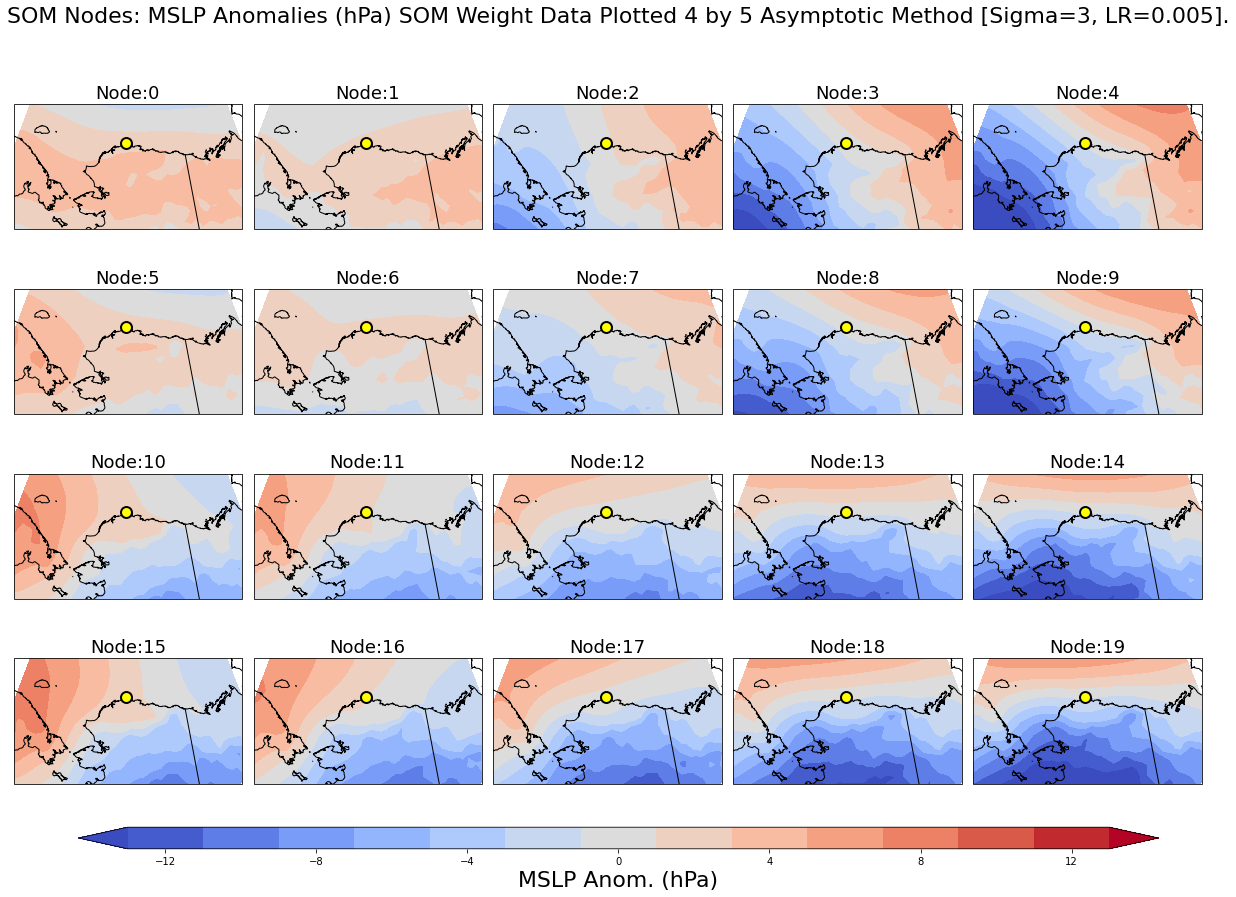

In [60]:
datacrs = ccrs.PlateCarree()
fig, axs = plt.subplots(nrows=4,ncols=5,
                        subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-156, central_latitude=71, standard_parallels=(30, 60))},
                        figsize=(30, 15),facecolor='white') 
fig.tight_layout()


axs=axs.flatten()
for k in range(weights.shape[0]):
    for i in range(weights.shape[1]):
        #node = (k,i)
        node=(k*5)+i
        SOM_mslp = weights[k,i,:].reshape(nx,ny)
        #levs = np.arange(-10, 10, 2)
        lev_start = -12
        lev_step= 2
        levs = (np.arange(lev_start-(lev_step/2), np.abs(lev_start)+(lev_step/2)+lev_step,lev_step))
        cs2=axs[(k*5)+i].contourf(lon, lat, SOM_mslp,
                          transform = ccrs.PlateCarree(),
                          cmap='coolwarm', levels = levs,extend='both')
        axs[(k*5)+i].set_extent([-131.7, -180, 73.48, 62.9], ccrs.PlateCarree() )
        
        axs[(k*5)+i].coastlines()
        axs[(k*5)+i].add_feature(cfeature.BORDERS) 
        axs[(k*5)+i].scatter(-156.36,71.19, c='yellow',marker= 'o',s=120, linewidth=2,edgecolors= "black" ,zorder= 4,transform=datacrs)
        

        # Title each subplot 
        axs[(k*5)+i].set_title('Node:'+str(node), fontsize=18)
     
        
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.6,
                    wspace=0.05, hspace=0.25)

cbar_ax = fig.add_axes([0.08, 0.2, 0.5, 0.02])
cbar=fig.colorbar(cs2,cax=cbar_ax, ticks = np.arange(lev_start, np.abs(lev_start)+lev_step, lev_step*2),orientation='horizontal')

cbar.set_label('MSLP Anom. (hPa)', fontsize=22)

plt.suptitle('SOM Nodes: MSLP Anomalies (hPa) SOM Weight Data Plotted 4 by 5 Asymptotic Method [Sigma=3, LR=0.005].', x= 0.33 ,fontsize=22)   
#plt.savefig("\\Users\\research\\thesis_code\\SOMs\\SOM_weights_5by4_LR0.005_sig5_SOM_som_8.p.png")

In [382]:
#Here you will be making a dataset that has all the times within the SOM. You will set the start to the first time within the SOM and the end as the last time within the SOM
# the SOM input data is resampled to every 6 hours so the frequency here is set to 6 hours 
ds_time = xr.Dataset({'time':pd.date_range(start='1979-01-01 00:00:00',
                                            end='2022-02-28 18:00:00', freq='6H')})
#The input data is only winter months so you will want to grab only the winter months which are Jan., Feb., March, April, Oct., Nov., and Dec.
ds_time_winter =ds_time.isel(time=ds_time.time.dt.month.isin([1,2,3,4,10,11,12]))

#You will want to set the values of the time to a variable.
time = ds_time_winter['time'].values

In [383]:
#Generate an empty array that is the size of the time dimension for the winning node number to be stored in as we want the winning node for each time stamp.
nodes = np.zeros([36744])
#Confirm that the array is of the right size.
nodes.shape

(36744,)

In [384]:
#You will loop through each hour and determine the winning node and then append that into the empty array we made in the previous block.
for i in range(nhours):
    w = som.winner(data_train[i,:])
    node = (w[0]*5)+w[1]
    nodes[i]+= [node] 

In [385]:
#The output from the previous code block is floats and we will be wanting the values as int's so this step changes them from floats to ints.
nodes = nodes.astype(int)

In [386]:
#Assign the nodes to a variable and put them in a list form for when we generate our Xarray.
Nodes = nodes.tolist()

In [387]:
Nodes

[4,
 4,
 4,
 4,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 7,
 7,
 8,
 9,
 4,
 4,
 4,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 4,
 4,
 3,
 4,
 9,
 9,
 14,
 9,
 9,
 9,
 14,
 14,
 14,
 14,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 7,
 7,
 2,
 3,
 3,
 4,
 4,
 4,
 9,
 9,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 9,
 9,
 9,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 11,
 11,
 6,
 6,
 6,
 11,
 11,
 11,
 15,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 16,
 16,
 16,
 15,
 15,
 16,
 16,
 16,
 15,
 15,
 15,
 10,
 5,
 5,
 0,
 0,
 5,
 5,
 10,
 15,
 15,
 15,
 10,
 11,
 11,
 11,
 10,
 6,
 5,
 0,
 0,
 0,
 0,
 5,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 7,
 7,
 8,
 8,
 4,
 4,
 4,
 4,
 3,
 3,
 2,
 7,
 7,
 6,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 11,
 11,
 11,
 11,
 10,
 15,
 1

In [388]:
#Generating an xarray that is of the dimension time.
ERA_Winning_Nodetimes = xr.Dataset(
    data_vars = dict(
        Node=(['time'], Nodes),
    ),
    coords=dict(
        time = (['time'],time),
       ),
    attrs=dict(
        description="Winning Nodes Times from ERA5 Data for 5by4_LR0.005_sig3_SOM_som_8.",
    ),

)    

In [389]:
ERA_Winning_Nodetimes['Node'][20976:20996]

<xarray.DataArray 'Node' (time: 20)>
array([1, 0, 0, 0, 0, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2])
Coordinates:
  * time     (time) datetime64[ns] 2003-10-31 ... 2003-11-04T18:00:00

In [390]:
#Here you will be making a dataset that has all the times within the SOM. I want it to be the same length in the time dimension as the ARM data so I a,
ds_time_new = xr.Dataset({'time':pd.date_range(start='2003-10-31 00:00:00',
                                            end='2022-04-30 23:00:00', freq='1H')})

In [391]:
ERA_dx = ERA_Winning_Nodetimes.reindex_like(ds_time_new, method='ffill')
#The missing points are filled in with the 

In [392]:
#The input data is only winter months so you will want to grab only the winter months which are Jan., Feb., March, April, Oct., Nov., and Dec.
new_ERA_dx =ERA_dx.isel(time=ERA_dx.time.dt.month.isin([1,2,3,4,10,11,12]))
new_ERA_dx

<xarray.Dataset>
Dimensions:  (time: 96072)
Coordinates:
  * time     (time) datetime64[ns] 2003-10-31 ... 2022-04-30T23:00:00
Data variables:
    Node     (time) int32 1 1 1 1 1 1 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
Attributes:
    description:  Winning Nodes Times from ERA5 Data for 5by4_LR0.005_sig3_SO...

In [393]:
#Save this dataset as a NetCDF
new_ERA_dx.to_netcdf('/Users/research/thesis_code/SOM_Code_Steps/5by4_LR0.005_sig3_SOM_som_8_WIN_NODE_TIMES_NO_NANs.nc')

In [256]:
#Open the NetCDF file to ensure that it worked.
#ERA_dx= xr.open_dataset(PATH + '5by4_LR0.005_sig5_SOM_som_8_WINNING_NODE_TIMES.nc')